In [1]:
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'  # For sharper figures, but it takes more time
import scipy as sp
from copy import deepcopy 

from lisatools.utils.constants import *
from lisatools.sensitivity  import SensitivityMatrix, AET1SensitivityMatrix

from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from bbhx.waveformbuild import BBHWaveformFD
from bbhx.utils.interpolate import CubicSplineInterpolant

from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

import noise_generation as noise_generation

No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.
No CuPy
No CuPy or GPU response available.


In [ ]:
Tobs = YRSID_SI / 2.
dt = 5.
N = int(Tobs / dt)
Tobs = N * dt

freq = np.fft.rfftfreq(N,dt)
freq[0] = freq[1]

plot_labels = ['A1TDISens', 'E1TDISens', 'T1TDISens']

#sens_mat = SensitivityMatrix(freq, [globals()[label] for label in plot_labels], **sens_kwargs)
#noises = noise_generation.generate_noise(N, dt, sens_mat, seed = 42, verification_plot=False, time_domain_plot=False, plot_lables=plot_labels)

In [3]:
wave_gen = BBHWaveformFD(amp_phase_kwargs=dict(run_phenomd=False), use_gpu=False)

m1 = 4e5
m2 = 2e5
chi1 = 0.5
chi2 = 0.7
dist = 200 * 1e9 * PC_SI
phi_ref = 0.0
f_ref = 0.0
inc = np.pi/3.
beta = np.pi/4.
lam = 2*np.pi/3.
psi = np.pi/6.
t_ref = Tobs/2

modes = [(2,2)]

wave_freq_domain = wave_gen(m1, m2, chi1, chi2,
                            dist, phi_ref, f_ref, inc, lam,
                            beta, psi, t_ref, 
                            freqs=freq, modes=modes, 
                            direct=False, fill=True, squeeze=True, length=1024)[0]

In [ ]:
def wrap(*args, **kwargs):
    return wave_gen(*args, **kwargs)[0]
data = DataResidualArray(wave_freq_domain, f_arr=freq)

sens_mat = AET1SensitivityMatrix(data.f_arr)

analysis = AnalysisContainer(data_res_arr=data, 
                             sens_mat=sens_mat, 
                             signal_gen=wrap)

analysis.snr()

43.83121200209682

In [5]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[8] = x[2]
    all_parameters[9] = x[3]

    all_parameters[np.array([2, 3, 4, 5, 6, 7, 10, 11])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
    )
    return ll

priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 1e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(-np.pi/2, np.pi/2),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist,
    phi_ref, 
    f_ref, 
    inc,
    psi,
    t_ref
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freq, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [6]:
from bbhx.likelihood import HeterodynedLikelihood

length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    wave_gen,
    freq,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

No CuPy


array([-22.94974426])

In [7]:
# clear (for internal clearing of answers)
 
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    all_parameters[8] = x[2]
    all_parameters[9] = x[3]
    all_parameters[np.array([2, 3, 4, 5, 6, 7, 10, 11])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [8]:
# clear (for internal clearing of answers)
 
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freq, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [29]:
coords = {"mbh": np.zeros((ntemps, nwalkers, 1, 4))}
coords["mbh"][:, :, 0] = priors["mbh"].rvs(size=(ntemps, nwalkers))
coords["mbh"].shape

(10, 32, 1, 4)

In [33]:
# clear (for internal clearing of answers)
injection_params_sub = np.array([m1 + m2, m2 / m1, lam, beta])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-1 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
#start_params[:, :, :, 3] = np.clip(start_params[:, :, :, 3], -np.pi/2, np.pi/2)
het_start_state = State({"mbh": coords["mbh"]})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|██████████| 1000/1000 [02:22<00:00,  7.02it/s]


In [51]:
print(het_sampler.get_chain()["mbh"].shape)
het_sampler.get_chain()["mbh"][999,9,0,0,:]

(1000, 10, 32, 1, 4)


array([ 6.31912873e+05,  5.30542836e-01,  5.91929952e+00, -1.26666946e+00])

Parameter mT in chain An Example Contour is not constrained
Parameter q in chain An Example Contour is not constrained
Parameter beta in chain An Example Contour is not constrained


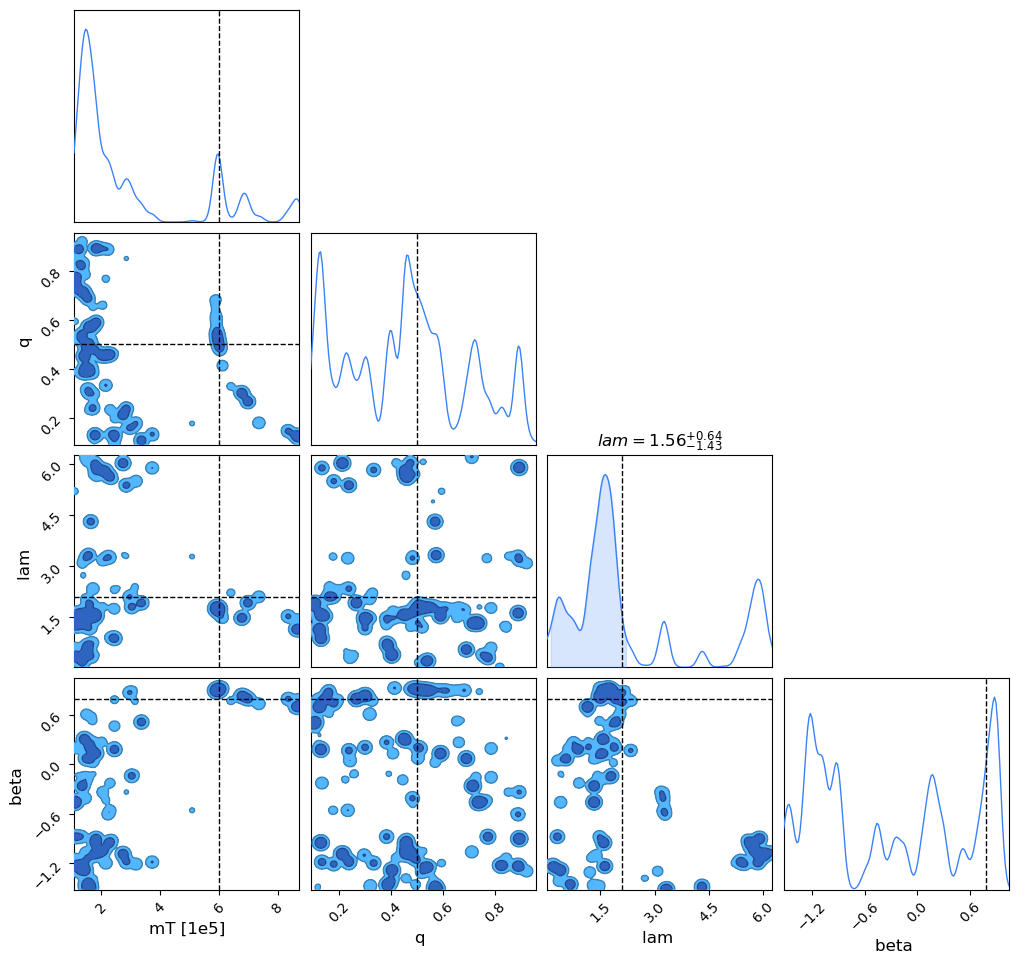

In [34]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "lam", "beta"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "lam": injection_params_sub[2], "beta": injection_params_sub[3]}))
fig = c.plotter.plot()

Injected values: m1+m2, m2/m1, lam, beta = (6e5, 0.5, 2.0943951023931953, 0.7853981633974483)